In [2]:
import theano
import theano.tensor as T
import lasagne
import numpy as np
import sklearn.datasets
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display

/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


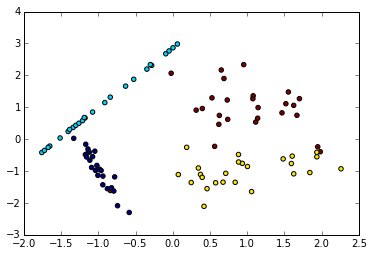

In [3]:
# Generate synthetic data
N_CLASSES = 4
X, y = sklearn.datasets.make_classification(
    n_features=2, n_redundant=0,
    n_classes=N_CLASSES, n_clusters_per_class=1)
# Convert to theano floatX
X = X.astype(theano.config.floatX)
# Labels should be ints
y = y.astype('int32')
# Make a scatter plot where color encodes class
plt.scatter(X[:, 0], X[:, 1], c=y)

In [10]:
l_in = lasagne.layers.InputLayer(shape=X.shape)

In [11]:

# We'll create a network with two dense layers: A tanh hidden layer and a softmax output layer.
l_hidden = lasagne.layers.DenseLayer(l_in, num_units=10, nonlinearity=lasagne.nonlinearities.tanh)
# For our output layer, we'll use a dense layer with a softmax nonlinearity.
l_output = lasagne.layers.DenseLayer(
    l_hidden, num_units=N_CLASSES, nonlinearity=lasagne.nonlinearities.softmax)

In [14]:

net_output = lasagne.layers.get_output(l_output)
print(net_output)

Softmax.0


In [15]:

# As a loss function, we'll use Lasagne's categorical_crossentropy function.
# This allows for the network output to be class probabilities,
# but the target output to be integers denoting the class.
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))

In [16]:
print(loss)

mean


In [17]:
# Retrieving all parameters of the network is done using get_all_params,
# which recursively collects the parameters of all layers connected to the provided layer.
all_params = lasagne.layers.get_all_params(l_output)
# Now, we'll generate updates using Lasagne's SGD function
updates = lasagne.updates.sgd(loss, all_params, learning_rate=1)
# Finally, we can compile Theano functions for training and computing the output.
# Note that because loss depends on the input variable of our input layer,
# we need to retrieve it and tell Theano to use it.
train = theano.function([l_in.input_var, true_output], loss, updates=updates)
get_output = theano.function([l_in.input_var], net_output)

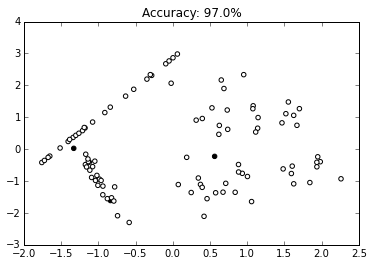

In [20]:
# Train (bake?) for 100 epochs
for n in xrange(100):
    train(X, y)
    
# Compute the predicted label of the training data.
# The argmax converts the class probability output to class label
y_predicted = np.argmax(get_output(X), axis=1)
# Plot incorrectly classified points as black dots
plt.scatter(X[:, 0], X[:, 1], c=(y != y_predicted), cmap=plt.cm.gray_r)
# Compute and display the accuracy
plt.title("Accuracy: {}%".format(100*np.mean(y == y_predicted)))